In [ ]:
# from google.colab import drive

# drive.mount('/content/drive/')
# %cd /content/drive/'My Drive'/DA_Assignment1/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/DA_Assignment1


In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint

In [ ]:
data = pd.read_csv('04_cricket_1999to2011.csv')
data = data[data.Innings == 1] # taking 1st innings data
matches_with_error= set()
df= data.copy()
df = df.groupby('Match').agg({'Over':'min'}).reset_index() # checking if match data not present from 1st over
for match in df[df['Over']!=1].Match.unique():
  matches_with_error.add(match)
data = data[~(data['Match'].isin(matches_with_error))]
data = data[~(data['Error.In.Data']==1)] # removing match data if 'Error.In.Data' is 1

In [ ]:
df1 = data[['Match', 'Runs']].copy() # checking if data in 'Innings.Total.Runs' column is consistent with data in 'Runs' column
df1 = df1.groupby('Match').agg({'Runs':'sum'}).reset_index()
df1.columns = ['Match', 'Innings.Total.Runs']
del data['Innings.Total.Runs'] # removing the 'Innings.Total.Runs' column
data = pd.merge(data, df1, on='Match') # correcting the data in 'Innings.Total.Runs' column

In [ ]:
# matches possibly interrupted by rain
df = data.copy()
df = df.groupby('Match').agg({'Over':'max', 'Wickets.in.Hand':'min','Innings.Total.Out':'max'})
interrupted_matches = df[(df['Innings.Total.Out'] <10) & (df['Over'] < 50)].reset_index()['Match'].unique()

In [ ]:
data = data[~(data.Match.isin(interrupted_matches))]

In [ ]:
data1 = data[['Match', 'Over', 'Total.Overs', 'Runs.Remaining', 'Wickets.in.Hand']].copy()
data1['Overs.Remaining'] = data1['Total.Overs'] - data1['Over']
data1 = data1[['Match', 'Runs.Remaining', 'Overs.Remaining',  'Wickets.in.Hand']]

# adding data with 'Wickets.in.Hand' = 10 and 'Overs.Remaining' = 'Total.Overs'
data2 = data[['Match', 'Over', 'Total.Overs', 'Innings.Total.Runs']].copy() 
data2 = data2.groupby('Match').first().reset_index()
data2['Wickets.in.Hand'] = 10
data2 = data2[['Match', 'Innings.Total.Runs', 'Total.Overs', 'Wickets.in.Hand']]
data2.columns = ['Match', 'Runs.Remaining', 'Overs.Remaining', 'Wickets.in.Hand'] 
data = pd.concat([data2, data1], axis = 0)
data.sort_values(['Match', 'Overs.Remaining'], ascending = [True, False], inplace = True)
data = data[['Overs.Remaining', 'Wickets.in.Hand', 'Runs.Remaining']]

In [ ]:
data10 = data[data['Wickets.in.Hand']==10]['Overs.Remaining']
y = data[data['Wickets.in.Hand']==10]['Runs.Remaining']

In [ ]:
from scipy import optimize
# comupting L 
def func(x, Z0, b):
    y = Z0 * (1 - np.exp(-b * x))
    return y

Z0, b = optimize.curve_fit(func, xdata = data10, ydata = y, p0 = [250, 0.5])[0]
L = Z0*b

print(f'L={L}')

L=10.55687286761824


In [ ]:
def func_w(x, Z0):
    y = Z0 * (1 - np.exp( (-L * x)/Z0))
    return y

In [ ]:
# computing Z0(1) ... Z0(10)
Z0 = dict()
for w in range(1,11):
  data_w = data[data['Wickets.in.Hand']==w]['Overs.Remaining']
  y_w = data[data['Wickets.in.Hand']==w]['Runs.Remaining']
  Z0[w] = optimize.curve_fit(func_w, xdata = data_w, ydata = y_w, p0 = [150+15*w])[0]

In [ ]:
print('Z0(w)')
pprint(Z0)

Z0(w)
{1: array([11.84862526]),
 2: array([27.41631793]),
 3: array([52.27721712]),
 4: array([81.59438428]),
 5: array([107.25234338]),
 6: array([142.32904841]),
 7: array([174.49966569]),
 8: array([214.37403942]),
 9: array([247.09618465]),
 10: array([290.79362667])}


In [ ]:
# computing mean square error
temp_data = data.copy()[data['Wickets.in.Hand']>0]
loss = temp_data.apply(lambda row: (row['Runs.Remaining'] - Z0[row['Wickets.in.Hand']] * (1 - np.exp(-L * row['Overs.Remaining'] / Z0[row['Wickets.in.Hand']]))) ** 2, axis = 1)
mse = loss.sum() / len(temp_data)
print(f'Mean Square Error  = {mse}')

Mean Square Error  = [1560.79060665]


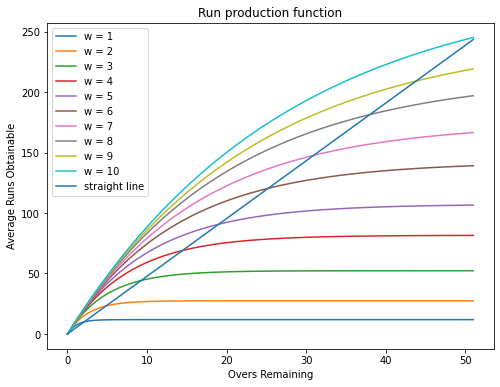

In [ ]:
import matplotlib.pyplot as plt
# plotting the run production functions
fig, ax = plt.subplots(figsize=(8, 6))
for w in range(1,11):
    x = np.linspace(0,51,100)
    y = Z0[w] * (1 - np.exp(-L * x / Z0[w]))
    ax.plot(x, y, label = 'w = {}'.format(w))
    
x = np.linspace(0, 51, 100)
slope = Z0[10] * (1 - np.exp(-L * 50 / Z0[10])) / 51
y = slope * x
ax.plot(x, y, label = 'straight line')

ax.legend(loc="upper left")
ax.set_title('Run production function')
ax.set_xlabel('Overs Remaining')
ax.set_ylabel('Average Runs Obtainable');